# SIC PROJECT



In [1]:
#requirements and dependencies
#check if the requirements are installed
requirements = ["tensorflow", "numpy", "cv2", "tqdm", "matplotlib", "tensorboard", "tensorflow_hub", "sklearn"]
#if not, quit
for requirement in requirements:
    try:
        __import__(requirement)
    except ImportError:
        print("You need to install the following package: " + requirement)
        print("You can do this by running: pip install " + requirement)
        quit()
print("All requirements are installed")

All requirements are installed


In [2]:
#import packages
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tqdm
import datetime
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import tensorboard
%load_ext tensorboard
print("success")

success


In [3]:
#check metal gpu
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices()

/device:GPU:0
Num GPUs Available:  1


2023-08-04 09:39:52.656813: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-08-04 09:39:52.656838: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-08-04 09:39:52.656841: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-08-04 09:39:52.657024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-04 09:39:52.657052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#load data
def load_data(path, IMG_SIZE=224):
    """
    Load image data from directory, resize and return it after converting it.
    return tuple `(images, labels)`.
    """
    categories = os.listdir(path)
    data = []
    labels = []
    for category in tqdm.tqdm(categories):
        folder_path = os.path.join(path, category)

        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(categories.index(category))

    return np.array(data), tf.keras.utils.to_categorical(labels)

In [5]:
#built from scratch model
def get_builtFromScartchModel(IMG_SIZE = 224, NUM_CLASSES = 3):
    
    #model architecture
    model = tf.keras.models.Sequential([

       tf.keras.layers.Conv2D(
           64, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)
       ),

       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

       tf.keras.layers.Dropout(0.25),

       tf.keras.layers.Conv2D(
           128, (3, 3), activation="relu"),

       tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

       tf.keras.layers.Dropout(0.25),

       tf.keras.layers.Flatten(),

       tf.keras.layers.Dense(128, activation="relu"),

       tf.keras.layers.Dropout(0.25),
       ##

       tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")

    ])

    # Compile Model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"]
    )
    #get model summary
    model.summary()
    
    return model

In [6]:
def get_trained_model(url, inputShape=(240, 240, 3), trainModel=True):
    "takes in the url of the tensorflow_hub  model and the input shape and the train option, returns the trained model attached to a classification head"
    feature_extractor_layer = hub.KerasLayer(
        url,
        input_shape = inputShape,
        trainable=trainModel
        )

    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(3, activation="softmax") #smoke, normal, fire
        ])
    
    #compile the model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    #display the model summary
    model.summary()
    
    return model

In [14]:
def evaluate(model, fitHistory, historyEval, test_data, test_labels):
    """
    Prints the metrics while fitting and testing the model and prints the confusion matrix.
    
    Args:
        model: A Keras model.
        fitHistory: A Keras History object returned by the `fit` method.
        predictHistory: The output of the `evaluate` method.
    """
    for i in range(len(model.metrics_names)):
        print(model.metrics_names[i] + ":\n"
               + "  while fitting: " + str(fitHistory.history[model.metrics_names[i]][-1]) + "\n"
               + "  while testing: " + str(historyEval[i]))
        
    print("-" * 50 + "\n")
    # print the cunfusion matrix #TODO: make it work for multiclass
    predictions = model.predict(test_data)
    predictions = np.argmax(predictions, axis=1)
    test_labels = np.argmax(test_labels, axis=1)
    print("-" * 50 + "\n")
    print("Confusion matrix:\n" + str(confusion_matrix(test_labels, predictions)))
    

In [8]:
#Data augmentation #TODO

In [12]:
#load data
train_data, train_labels = load_data('Train')
test_data, test_labels = load_data('Test')

#load model
model = get_builtFromScartchModel()

#some parameters
EPOCHS = 1
IMG_SIZE = 224
BATCH_SIZE = 100

#for tensorboard
log_dir = "logs/fit/" + str(len(os.listdir('logs/fit')) + 1) if os.path.exists('logs/fit') else "logs/fit/1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,  histogram_freq=1)

#split the data into validation and train %20 validation %80 train
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
#train and validate the model
historyFit = model.fit(x = train_data, y = train_labels, validation_data= (val_data, val_labels), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[tensorboard_callback])
#evaluate the model
historyEval = model.evaluate(test_data, test_labels, callbacks=[tensorboard_callback])

100%|██████████| 3/3 [00:00<00:00, 18.69it/s]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 111, 111, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 54, 54, 128)      

2023-08-04 09:41:19.340378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - ETA: 0s - loss: 6052.9302 - categorical_accuracy: 0.3409

2023-08-04 09:41:34.007271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 73ms/step - loss: 1.3198 - categorical_accuracy: 0.3667


In [15]:
#evaluate the built from scratch model
evaluate(model, historyFit, historyEval, test_data, test_labels)

loss:
  while fitting: 6052.93017578125
  while testing: 1.3198078870773315
categorical_accuracy:
  while fitting: 0.3408985733985901
  while testing: 0.36666667461395264
--------------------------------------------------

10/10 [==============================] - 1s 73ms/step
--------------------------------------------------

Confusion matrix:
[[87  2 11]
 [49  5 46]
 [80  2 18]]


In [17]:
# Load the EfficientNetV2 pre-trained model from TensorFlow Hub, recommended input size is 240x240 pixels
module_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/classification/2"
model = get_trained_model(module_url)

#load data
train_data, train_labels = load_data('Train', 240)
test_data, test_labels = load_data('Test', 240)

#split data, 20% for validation
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

#for tensorboard
log_dir = "logs/fit/" + str(len(os.listdir('logs/eval')) + 1) if os.path.exists('logs/eval') else "logs/eval/1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,  histogram_freq=1)

#some parameters
EPOCHS = 10
BATCH_SIZE = 32

with tf.device('/device:GPU:0'):
  historyFit = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(val_data, val_labels), callbacks=[tensorboard_callback], batch_size=BATCH_SIZE)
  historyEval = model.evaluate(test_data, test_labels)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1000)              8212124   
                                                                 
 dense_7 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 8215127 (31.34 MB)
Trainable params: 8144055 (31.07 MB)
Non-trainable params: 71072 (277.62 KB)
_________________________________________________________________


100%|██████████| 3/3 [00:00<00:00,  7.20it/s]


Epoch 1/10


2023-08-04 09:45:41.348063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - ETA: 0s - loss: 0.4553 - categorical_accuracy: 0.8069

2023-08-04 09:46:38.723542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 74s 827ms/step - loss: 0.4553 - categorical_accuracy: 0.8069 - val_loss: 0.1511 - val_categorical_accuracy: 0.9463
Epoch 2/10
68/68 [==============================] - 33s 475ms/step - loss: 0.1006 - categorical_accuracy: 0.9676 - val_loss: 0.1140 - val_categorical_accuracy: 0.9593
Epoch 3/10
68/68 [==============================] - 34s 506ms/step - loss: 0.0684 - categorical_accuracy: 0.9759 - val_loss: 0.1081 - val_categorical_accuracy: 0.9630
Epoch 4/10
68/68 [==============================] - 34s 498ms/step - loss: 0.0428 - categorical_accuracy: 0.9875 - val_loss: 0.1089 - val_categorical_accuracy: 0.9648
Epoch 5/10
68/68 [==============================] - 32s 466ms/step - loss: 0.0383 - categorical_accuracy: 0.9866 - val_loss: 0.0967 - val_categorical_accuracy: 0.9741
Epoch 6/10
68/68 [==============================] - 33s 488ms/step - loss: 0.0348 - categorical_accuracy: 0.9898 - val_loss: 0.0975 - val_categorical_accuracy: 0.9704
Epoch 7/1

loss:
  while fitting: 0.024076996371150017
  while testing: 0.15201044082641602
categorical_accuracy:
  while fitting: 0.9939786791801453
  while testing: 0.9599999785423279
--------------------------------------------------



2023-08-04 09:52:12.753700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 8s 278ms/step
--------------------------------------------------

Confusion matrix:
[[95  2  3]
 [ 0 98  2]
 [ 4  1 95]]
['Smoke', 'Neutral', 'Fire']


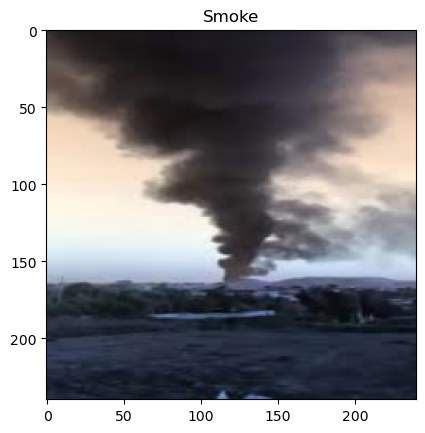

1/1 [==============================] - 2s 2s/step
[[9.9657452e-01 2.6276798e-06 3.4229257e-03]]


In [18]:
evaluate(model, historyFit, historyEval, test_data, test_labels)
##Random image prediction
# Assuming val_data and val_label are already defined
random_index = np.random.randint(len(test_data))
random_image = test_data[random_index]
random_label = test_labels[random_index]
class_vector = np.argmax(random_label)

categories = os.listdir('Test')
print(categories)

# Display the image and its label
plt.imshow(random_image)
plt.title(categories[class_vector])
plt.show()
#predict the image
prediction = model.predict(random_image.reshape((-1, 240, 240,3)))
print(prediction)

In [ ]:
#lunch tensorboard to plot the results and the graphs
%tensorboard --logdir logs --port=6910